In [22]:
import json 
import os
import numpy as np
def _removeNonAscii(s): return "".join(i for i in s if ord(i)<128)

# load tweets
tweets = []
chars = set()
path = 'ECE219_tweet_data/'
files = os.listdir(path)
print(files)

# Get set of Seahawks and Patriots fans
# Seahawks fans are those who used the #gohawks hashtag at least once,
# and Patriots fans have used the #gopatriots hashtag at least once
pats_fans = set()
hawks_fans = set()

for line in open(path+'tweets_#gohawks.txt', 'r'):
    tweet = json.loads(line)
    hawks_fans.add(tweet['tweet']['user']['id'])
    
for line in open(path+'tweets_#gopatriots.txt', 'r'):
    tweet = json.loads(line)
    pats_fans.add(tweet['tweet']['user']['id'])

hawks_fans = hawks_fans - pats_fans
pats_fans = pats_fans - hawks_fans 


['tweets_#nfl.txt', 'tweets_#superbowl.txt', 'tweets_#sb49.txt', 'tweets_#patriots.txt', 'tweets_#gohawks.txt', 'tweets_#gopatriots.txt']


In [23]:
import pytz
import datetime

# Get the tweets of Patriots and Seahawks fans that occured during 
# the game in 1-minute intervals
startmin = int(1422833400 / 60) # game start
stopmin = int(1422847800 / 60) # game end
pst_tz = pytz.timezone('America/Los_Angeles') 
print(datetime.datetime.fromtimestamp(1422833400, pst_tz))
print(datetime.datetime.fromtimestamp(1422847800, pst_tz))

pats_tweets = [[] for stamp in range(startmin,stopmin)]
hawks_tweets = [[] for stamp in range(startmin,stopmin)]
for f in files:
    for line in open(path+f, 'r'):
        tweet = json.loads(line)
        if tweet['tweet']['lang'] == "en":
            if tweet['tweet']['user']['id'] in pats_fans:
                pat = True
            elif tweet['tweet']['user']['id'] in hawks_fans:
                pat = False
            else:
                continue
            tweet = json.loads(line)
            t = tweet['citation_date'] / 60
            idx = int(t-startmin)
        
            if idx >= 0 and idx < stopmin - startmin:
                text = _removeNonAscii(tweet['tweet']['text'])
                if pat:
                    pats_tweets[idx].append(text)
                else:
                    hawks_tweets[idx].append(text)
                


2015-02-01 15:30:00-08:00
2015-02-01 19:30:00-08:00


In [24]:
# Sentiment Analysis: Determine if tweets are positive or negative
# based on key words
pos_words = ['go', 'big', 'huge', 'win', 'beat', 'best', 'good', 'great', 'love', 'score', 'touchdown', 'yes', 'happy', 'excited']
neg_words = ['bad', 'suck', 'damn', 'need', 'hurt', 'fail', 'lose', 'terrible', 'worst', 'poor', 'no', 'angry', 'mad', 'cry', 'stupid', 'dumb', 'hell', 'wtf', 'shit', 'fuck']


In [25]:
# Process the tweets
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
# Convert tweets to TF-IDF
import random
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk import pos_tag
from nltk.corpus import stopwords
from string import punctuation
import pandas as pd

def build_vectorizer(min_df):
    wnl = nltk.wordnet.WordNetLemmatizer()
    stop_words_skt = text.ENGLISH_STOP_WORDS
    stop_words_en = stopwords.words('english')
    combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
    
    analyzer = CountVectorizer().build_analyzer()

    def lemmatize_sent(list_word):
        # Text input is string, returns array of lowercased strings(words).
        return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
                for word, tag in pos_tag(list_word)]
            
    def stem_rmv_punc(doc):
        return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

    def penn2morphy(penntag):
        """ Converts Penn Treebank tags to WordNet. """
        morphy_tag = {'NN':'n', 'JJ':'a',
                'VB':'v', 'RB':'r'}
        try:
            return morphy_tag[penntag[:2]]
        except:
            return 'n'

    return CountVectorizer(min_df=min_df, analyzer=stem_rmv_punc, stop_words='english')


def get_sentiment(data, min_df=3):
    
    count_vect = build_vectorizer(min_df=min_df)
    X_train_counts = count_vect.fit_transform(data)
    x = pd.SparseDataFrame(X_train_counts, columns=count_vect.get_feature_names() 
                                , default_fill_value=0)
    scores = []
    for index, row in x.iterrows():
        pos = 0
        neg = 0
        words = row.to_dict()
        
        for p in pos_words:
            pos += words.get(p,0)
        for n in neg_words:
            neg += words.get(n,0)
        scores.append(np.sign(pos - neg))
        
    return np.mean(scores)

def vectorize_data(data, test, min_df=3):
    
    count_vect = build_vectorizer(min_df=min_df)
    
    X_train_counts = count_vect.fit_transform(data)
    X_test_counts = count_vect.transform(test)

    # Report the shape of the TF-IDF matrices of the train and test subsets respectively**
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)

    return X_train_tfidf, X_test_tfidf



[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1045)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1045)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:1045)>


In [26]:
data_pats = []
data_hawks = []
sentiments_pats = []
sentiments_hawks = []
for i in range(240):
    sentiments_pats.append(get_sentiment(pats_tweets[i]))
    sentiments_hawks.append(get_sentiment(hawks_tweets[i]))
    
    

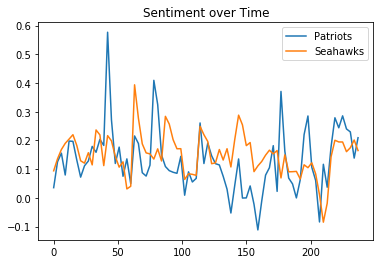

In [27]:
# Reduce sentiments to 3-minute intervals
import matplotlib.pyplot as plt
pats = []
hawks = []
indx =  range(0,240,3)
for i in indx:
    pats.append(np.mean(sentiments_pats[i:i+3]))
    hawks.append(np.mean(sentiments_hawks[i:i+3]))
plt.plot(indx, pats, label='Patriots')
plt.plot(indx, hawks,  label='Seahawks')
plt.legend()
plt.title("Sentiment over Time")
plt.show()

In [28]:
# Break the game into 73 3-minute intervals
# Target to predict y_i = 1 when game event occurs during interval i 
# and 0 otherwise
true_events = [24, 42, 63, 78,89,125,138,144,178,199,212]
y = np.zeros(73)
for i in range(0,219):
    if i in true_events:
        y[int(i/3)] = 1


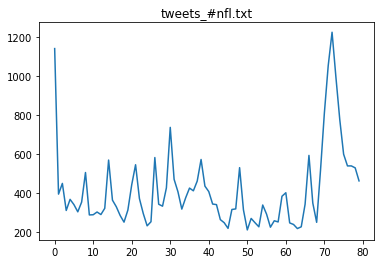

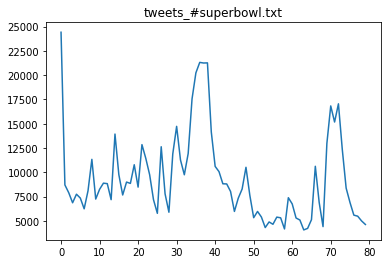

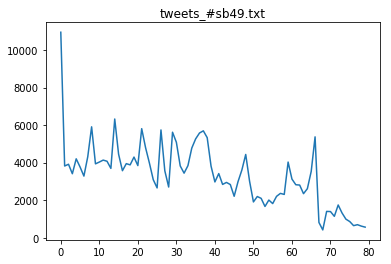

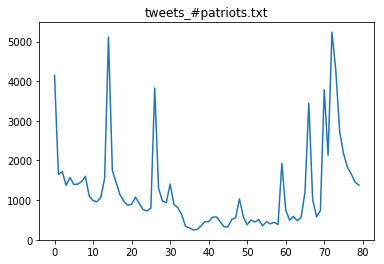

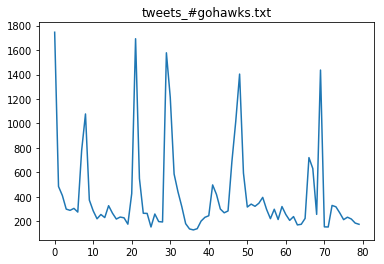

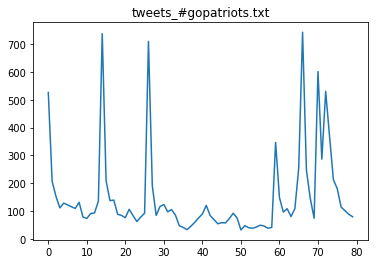

In [29]:
# calculate tweet volumne during 3-minute intervals
startmin = int(1422833400 / 180)
stopmin = int(1422847800 / 180)
number_of_tweets = {}

for f in files:
    number_of_tweets[f] = [0 for stamp in range(startmin,stopmin)]
    for line in open(path+f, 'r'):
        tweet = json.loads(line)
        t = tweet['citation_date'] / 180
        idx = int(t-startmin)
        if idx >= 0 and idx < stopmin - startmin:
            number_of_tweets[f][idx] += 1
            #if tweet['tweet']['lang'] == "en":
            #   text = _removeNonAscii(tweet['tweet']['text'])
            #   tweets[f][idx].append(text)
                
    plt.figure()
    plt.plot(number_of_tweets[f]) 
    plt.title(f)
    plt.show()
    


In [30]:
# find locations of the peaks in tweet volume
def find_peak(tweets,cutoff):
    
    N = len(tweets)
    peaks = np.zeros(N)
    prev = np.inf
    rising = False
    
    for i in range(N):
        if prev > cutoff and rising and tweets[i] < prev:
            #print("Found max at %d" % (i-1))
            peaks[i-1] = 1
        if tweets[i] > prev:
            rising = True
                
        else:
            rising = False
        prev = tweets[i]
    return peaks

p_peaks = find_peak(number_of_tweets['tweets_#gopatriots.txt'][0:73],0)
h_peaks = find_peak(number_of_tweets['tweets_#gohawks.txt'][0:73],0)

In [31]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Try to predict events using difference in sentiment & tweet volume
sentiments = np.array(pats) - np.array(hawks)

# stack features
X = np.vstack((sentiments[0:73], p_peaks, h_peaks, number_of_tweets['tweets_#gopatriots.txt'][0:73]/ np.max(number_of_tweets['tweets_#gopatriots.txt'] ), 
                             number_of_tweets['tweets_#gohawks.txt'][0:73]/ np.max(number_of_tweets['tweets_#gohawks.txt']))).T
y = y[:73]
# Use leave one out validation
loo = LeaveOneOut()
metrics = []
max_depth = [2,3,4,5,6,7,8,9,10]
for d in max_depth:
    preds = []
    actual = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = RandomForestClassifier(n_estimators=500, max_depth=d, random_state=0, class_weight='balanced')
        clf.fit(X_train, y_train)
        preds.append(clf.predict(X_test)[0])
        actual.append(y_test[0])
    metrics.append(recall_score(actual, preds))

best_depth = max_depth[np.argmax(metrics)]
print("Best Depth: %d" % best_depth)

    


Best Depth: 2


In [32]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier


best_depth = 2
X = np.vstack((sentiments[0:73], p_peaks, h_peaks, number_of_tweets['tweets_#gopatriots.txt'][0:73]/ np.max(number_of_tweets['tweets_#gopatriots.txt'] ), 
                             number_of_tweets['tweets_#gohawks.txt'][0:73]/ np.max(number_of_tweets['tweets_#gohawks.txt']))).T

loo = LeaveOneOut()

preds = []
actual = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestClassifier(n_estimators=500, max_depth=best_depth, random_state=0, class_weight='balanced')
    clf.fit(X_train, y_train)
    preds.append(clf.predict(X_test)[0])
    actual.append(y_test[0])


print(confusion_matrix(actual, preds))
print("Accuracy: %f " % accuracy_score(actual,preds))
print("Precision: %f " % precision_score(actual, preds))
print("Recall: %f " % recall_score(actual, preds))


[[59  3]
 [ 2  9]]
Accuracy: 0.931507 
Precision: 0.750000 
Recall: 0.818182 


In [33]:
# Get time of event predictions, and what team benefited from the event
events = []
pred_team = []
true_team = [0,1,0,1,0,0,0,0,1,1,1]
for i,p in enumerate(preds):
    if p == 1:
        events.append(i*3)
        if sentiments[i] > 0:
            pred_team.append(1)
        else:
            pred_team.append(0)


true_events = list(np.array([24, 42, 63, 78,89,125,138,144,178,199,212]) // 3)
acc = 0
total = 0
y = np.zeros(73)
for i,e in enumerate(events):
    if (e//3) in true_events:
        total += 1
        idx = true_events.index(e//3)
        if true_team[idx] == pred_team[i]:
            acc += 1
print("Accuracy of team prediction: %f" % (acc / total))


Accuracy of team prediction: 0.888889


In [13]:
# Dimension Reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd

def LSI_(X_train_tfidf, X_test_tfidf, n=50):

    svd = TruncatedSVD(n_components=n, random_state=0)
    
    # print U.shape, Sigma.shape, VT.shape
    X_train_r = svd.fit_transform(X_train_tfidf)
    X_test_r = svd.transform(X_test_tfidf)
    return X_train_r, X_test_r

In [15]:
# Generate tweets about the events
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import time
import functools

seq_length = 50

tf.enable_eager_execution()

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

rnn = functools.partial(tf.keras.layers.GRU, recurrent_activation='sigmoid')
def build_model(num_chars, batch_size=32):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_chars, 256, 
                              batch_input_shape=[batch_size, None]),
        rnn(1024,
            return_sequences=True, 
            recurrent_initializer='glorot_uniform',
            stateful=True),
        tf.keras.layers.Dense(num_chars)
      ])
    return model

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)


In [16]:
def generate_text(model, start_string, num_generate = 500):
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))



In [10]:
import numpy as np
for i,t in enumerate(events):
    print("Event time: %d" % t)
    text = ''
    if pred_team[i] == 1:
        tweets = pats_tweets
    else: 
        tweets = hawks_tweets
    for i in range(t-1,t+2):
        for tweet in tweets[i]:
            text += tweet + '\n'
    chars = sorted(set(text))
    char2idx = {u:i for i, u in enumerate(chars)}
    idx2char = np.array(chars)

    text_as_int = np.array([char2idx[c] for c in text])
    examples_per_epoch = len(text)//seq_length
    char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
    sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
    dataset = sequences.map(split_input_target)
    dataset = dataset.shuffle(10000).batch(32, drop_remainder=True)
    steps_per_epoch = examples_per_epoch//32
    
    model = build_model(
        num_chars = len(chars))

    model.compile(
        optimizer = tf.train.AdamOptimizer(),
        loss = loss)

    history = model.fit(dataset.repeat(), epochs=50, steps_per_epoch=steps_per_epoch)
    model.save_weights('weights.hd5')
    
    model = build_model(len(chars), batch_size=1)
    model.load_weights('weights.hd5')
    model.build(tf.TensorShape([1, None]))

    print(generate_text(model, start_string=u"\n"))

Event time: 24
Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/50
78/78 [==============================] - 19s 239ms/step - loss: 3.3880
Epoch 2/50
78/78 [==============================] - 17s 212ms/step - loss: 2.0910
Epoch 3/50
78/78 [==============================] - 16s 210ms/step - loss: 1.8024
Epoch 4/50
78/78 [==============================] - 16s 210ms/step - loss: 1.6409
Epoch 5/50
78/78 [==============================] - 17s 212ms/step - loss: 1.5233
Epoch 6/50
78/78 [==============================] - 17s 212ms/step - loss: 1.4201
Epoch 7/50
78/78 [==============================] - 17s 213ms/step - loss: 1.3297
Epoch 8/50
78/78 [==============================] - 17s 212ms/step - loss: 1.2378
Epoch 9/50
78/78 [==============================] - 16s 211ms/step - loss: 1.1505
Epoch 10/50
78/78 [==============================] - 16s 211ms/step - loss: 1.0628
Epoch 11/50
78/78 [==============================] - 16s 210ms/step - loss: 0.9786
Epoch 12/